In [1]:
#!/usr/bin/env python
"""
Definition of test problems
--------------------------------------------------------------------------
Created December 10, 2022 for TRIPs-Py library
"""
__authors__ = "Mirjeta Pasha and Connor Sanderford"
__copyright__ = "Copyright 2022, TRIPs-Py library"
__license__ = "GPL"
__version__ = "0.1"
__maintainer__ = "Mirjeta Pasha and Connor Sanderford"
__email__ = "mirjeta.pasha@tufts.edu; mirjeta.pasha1@gmail.com and csanderf@asu.edu; connorsanderford@gmail.com"

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pylops

from scipy import linalg as la
from scipy import sparse

from trips.io import build_x_true
from trips.operators import gaussian_blur_operator, first_derivative_operator
from trips.solvers.GKS import *

### construct a true image

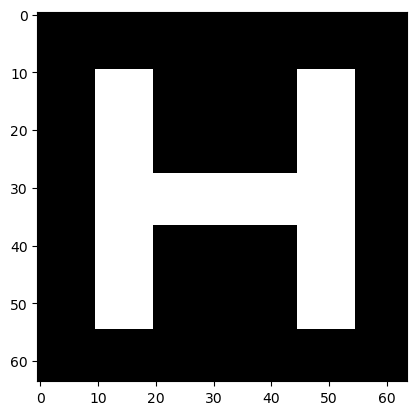

In [4]:
x_true = build_x_true().reshape(-1,1)

plt.imshow(x_true.reshape(64,64), cmap='Greys_r')

### apply an operator

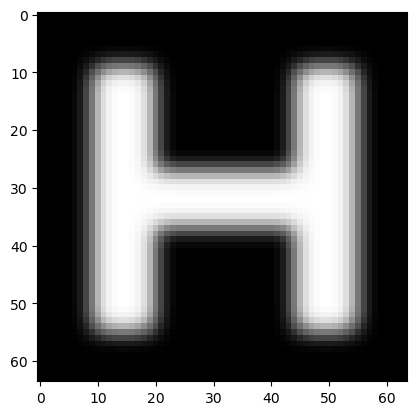

In [5]:
blur_operator = gaussian_blur_operator([9,9],2,64,64)

b_true = blur_operator @ x_true

plt.imshow( b_true.reshape(64,64), cmap='Greys_r')

### contaminate with noise

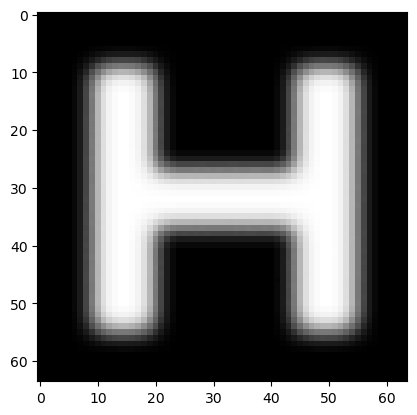

In [6]:
noise_level = 0.001
noise = np.random.randn(64*64)
e = noise_level * np.linalg.norm(b_true) / np.linalg.norm(noise) * noise
e = e.reshape(-1,1)
b = b_true + e
plt.imshow( b.reshape(64,64), cmap='Greys_r')

### construct regularization operators

In [7]:
I = pylops.Identity(4096) # identity operator
D = first_derivative_operator(n=4096) # first derivative operator
D2 = D @ D # second derivative operator

### run GKS with GCV

In [8]:
solver = GKSClass(projection_dim=3, regparam='gcv', dp_stop=False, tol=10**(-16))
solver.run(blur_operator, b, D, iter=80, x_true=x_true)

running GKS...:   0%|          | 0/50 [00:00<?, ?it/s]

running GKS...: 100%|██████████| 50/50 [00:05<00:00,  8.65it/s]


array([[-0.00342477],
       [-0.00885885],
       [-0.02721443],
       ...,
       [-0.00286711],
       [-0.01798914],
       [-0.011526  ]])

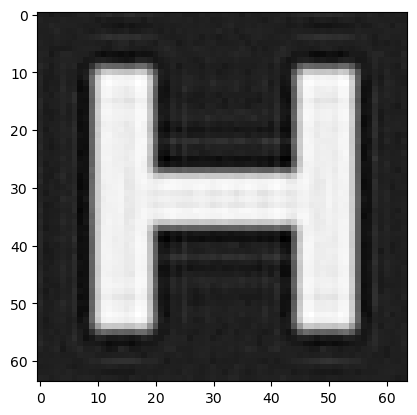

In [9]:
plt.imshow(solver.x.reshape(64,64), cmap='Greys_r')

### Convergence

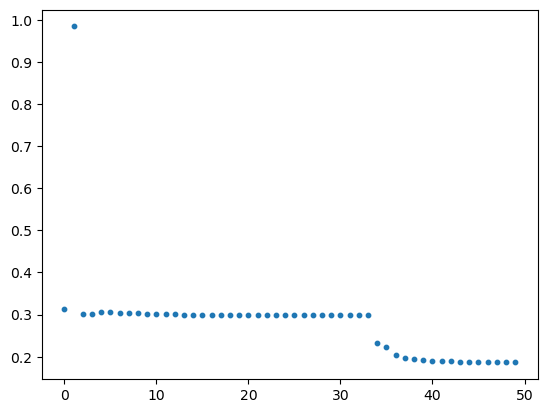

In [10]:
plt.scatter(range(len(solver.rre_history)), solver.rre_history, s=10)

### history of solutions

IndexError: list index out of range

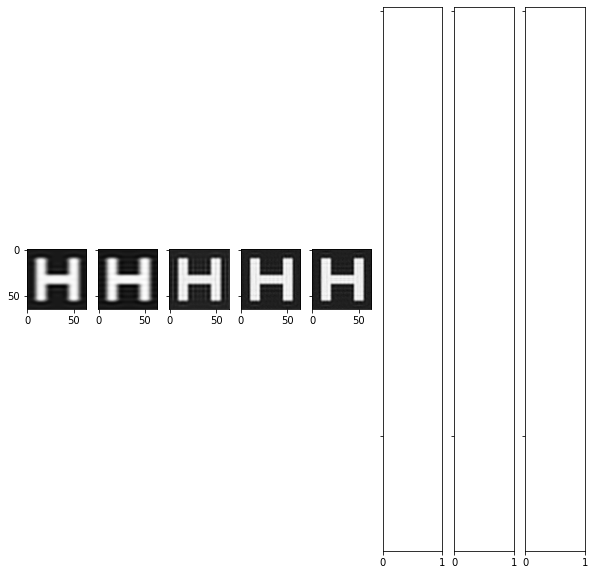

In [9]:
fig, ax = plt.subplots(1, 8, figsize=(10, 10), sharey=True)

for ii in range(8):
    ax[ii].imshow(solver.x_history[9+10*ii].reshape(64,64), cmap='Greys_r')

plt.show()

### history of lambda values

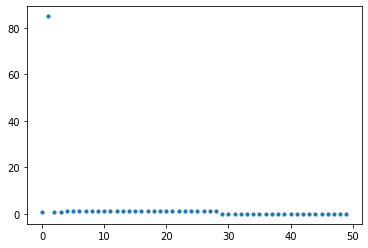

In [10]:
plt.scatter(range(len(solver.lambda_history)), solver.lambda_history, s=10)

### run GKS with DP

In [78]:
solver = GKSClass(projection_dim=3, regparam='dp', dp_stop=False, eta=1.01, delta=la.norm(e), tol=10**(-16))
solver.run(blur_operator, b, D, iter=80, x_true=x_true)

running GKS...:  64%|██████▍   | 32/50 [00:01<00:00, 23.07it/s]/Users/mirjetapasha/opt/anaconda3/envs/astra/lib/python3.9/site-packages/trips/parameter_selection/discrepancy_principle.py:56: RuntimeWarning: divide by zero encountered in true_divide
  beta_new = beta - f/f_prime
/Users/mirjetapasha/opt/anaconda3/envs/astra/lib/python3.9/site-packages/trips/parameter_selection/discrepancy_principle.py:59: RuntimeWarning: invalid value encountered in subtract
  if abs(beta_new - beta) < 10**(-7)* beta:
running GKS...:  70%|███████   | 35/50 [00:01<00:00, 21.11it/s]/Users/mirjetapasha/opt/anaconda3/envs/astra/lib/python3.9/site-packages/trips/parameter_selection/discrepancy_principle.py:56: RuntimeWarning: overflow encountered in true_divide
  beta_new = beta - f/f_prime
running GKS...: 100%|██████████| 50/50 [00:02<00:00, 20.89it/s]


array([[ 0.01032925],
       [ 0.00577163],
       [-0.00646217],
       ...,
       [-0.0104062 ],
       [-0.00795786],
       [ 0.00596684]])

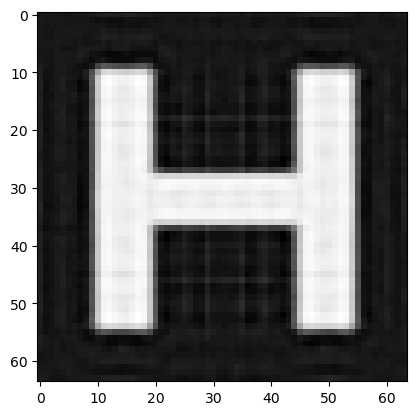

In [79]:
plt.imshow(solver.x.reshape(64,64), cmap='Greys_r')

### convergence

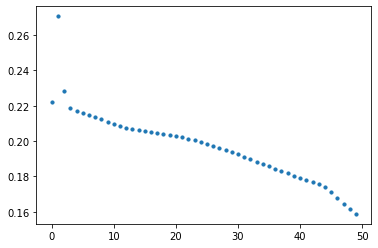

In [13]:
plt.scatter(range(len(solver.rre_history)), solver.rre_history, s=10)

### history of solutions

IndexError: list index out of range

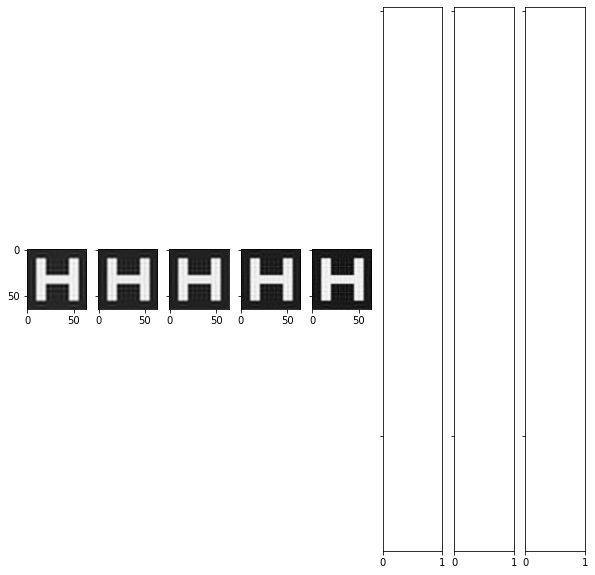

In [14]:
fig, ax = plt.subplots(1, 8, figsize=(10, 10), sharey=True)

for ii in range(8):
    ax[ii].imshow(solver.x_history[9+10*ii].reshape(64,64), cmap='Greys_r')

plt.show()

### history of lambda values

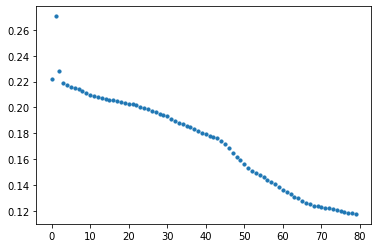

In [ ]:
plt.scatter(range(len(solver.rre_history)), solver.rre_history, s=10)

### run GKS with a sequence of parameter values

In [ ]:
regvals = [0.001*(0.5**(x)) for x in range(0,80)]

In [ ]:
solver = GKSClass(projection_dim=3, regparam=regvals, dp_stop=False, tol=10**(-16))
solver.run(blur_operator, b, D, iter=80, x_true=x_true)

running GKS...: 100%|██████████| 80/80 [00:03<00:00, 23.13it/s] 


array([[-0.01873864],
       [-0.00111126],
       [ 0.02966203],
       ...,
       [-0.0084036 ],
       [ 0.00189183],
       [ 0.00283511]])

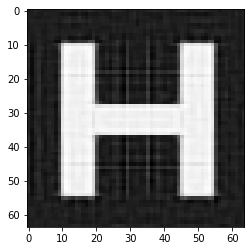

In [ ]:
plt.imshow(solver.x.reshape(64,64), cmap='Greys_r')

### convergence

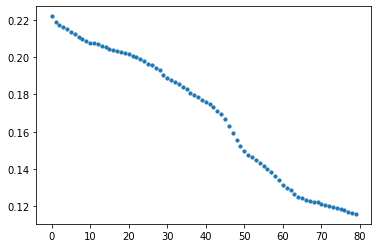

In [ ]:
plt.scatter(range(len(solver.rre_history)), solver.rre_history, s=10)

### history of solutions

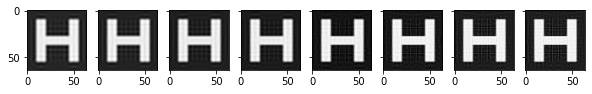

In [ ]:
fig, ax = plt.subplots(1, 8, figsize=(10, 10), sharey=True)

for ii in range(8):
    ax[ii].imshow(solver.x_history[9+10*ii].reshape(64,64), cmap='Greys_r')

plt.show()

### history of lambda values

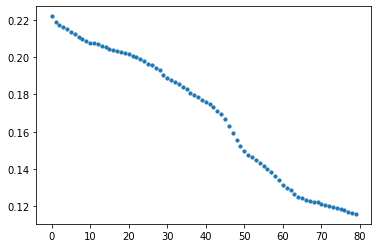

In [ ]:
plt.scatter(range(len(solver.rre_history)), solver.rre_history, s=10)

### run GKS with a sequence of parameter values, initialized by gcv

In [ ]:
# first, run several iterations with crossvalidation.
solver = GKSClass(projection_dim=3, regparam='gcv', dp_stop=False, tol=10**(-16))
solver.run(blur_operator, b, D, iter=10, x_true=x_true)

# then use the estimated to initialize a sequence of values.
regvals = [solver.lambda_history[-1]*(0.5**(x)) for x in range(0,80)]
solver.change_regparam(regvals)
solver.run(blur_operator, b, D, iter=80, x_true=x_true, warm_start=True)

running GKS...: 100%|██████████| 80/80 [00:04<00:00, 17.46it/s]


array([[-0.02112575],
       [-0.00445612],
       [ 0.03421515],
       ...,
       [-0.00238307],
       [-0.00087614],
       [-0.00867888]])

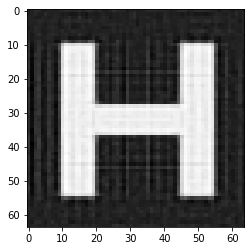

In [ ]:
plt.imshow(solver.x.reshape(64,64), cmap='Greys_r')

### convergence

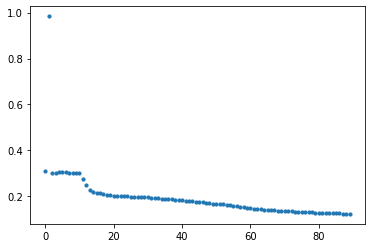

In [ ]:
plt.scatter(range(len(solver.rre_history)), solver.rre_history, s=10)

### history of solutions

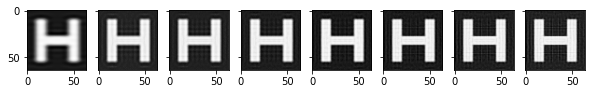

In [ ]:
fig, ax = plt.subplots(1, 8, figsize=(10, 10), sharey=True)

for ii in range(8):
    ax[ii].imshow(solver.x_history[10+10*ii].reshape(64,64), cmap='Greys_r')

plt.show()

### history of lambda values

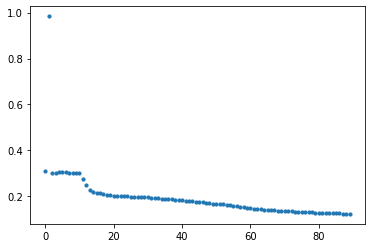

In [ ]:
plt.scatter(range(len(solver.rre_history)), solver.rre_history, s=10)

In [71]:
class GKSCl:

    def __init__(self, projection_dim=3, regparam='gcv', projection_method='auto', **kwargs):

        self.projection_dim = projection_dim
        self.projection_method = projection_method
        self.regparam = regparam

        self.kwargs = kwargs

        self.dp_stop = kwargs['dp_stop'] if ('dp_stop' in kwargs) else False

        

        self.x_history = []
        self.lambda_history = []
        

    def change_regparam(self, regparam='gcv'):
        self.regparam = regparam


    def _project(self, A, b, projection_dim=None, **kwargs):
        
        if projection_dim is not None:

            if ((self.projection_method == 'auto') and (A.shape[0] == A.shape[1])) or (self.projection_method == 'arnoldi'):


                (basis,_) = arnoldi(A, b, projection_dim, self.dp_stop, **kwargs)

            else:
                (_, _, basis) = golub_kahan(A, b, projection_dim, self.dp_stop, **kwargs)
        
        else:
            
            if ((self.projection_method == 'auto') and (A.shape[0] == A.shape[1])) or (self.projection_method == 'arnoldi'):

                if A.shape[0] == A.shape[1]:
                    (basis,_) = arnoldi(A, b, projection_dim, self.dp_stop, **kwargs)

                else:
                   (_, _, basis) = golub_kahan(A, b, self.projection_dim, self.dp_stop, **kwargs)

        self.basis = basis

        return basis
    
    def restart(self):
        self.basis = None

    def run(self, A, b, L, n_iter=50, warm_start=False, x_true=None, **kwargs):

        self.regparam_sequence = kwargs['regparam_sequence'] if ('regparam_sequence' in kwargs) else [0.1*(0.5**(x)) for x in range(0,n_iter)]

        if warm_start == False:

            self._project(A, b, self.projection_dim)

            x = A.T @ b # initialize x to b for reweighting
            self.x = x

        x = self.x

        for ii in tqdm(range(n_iter), 'running GKS...'):

            if is_identity(L):

                Q_A, R_A, _ = la.svd(A @ self.basis, full_matrices=False)

                (Q_L, R_L) = (Identity(L.shape[0]) @ self.basis, Identity(L.shape[0]) @ self.basis)

                R_A = np.diag(R_A)

            else:

                (Q_A, R_A) = la.qr(A @ self.basis, mode='economic') # Project A into V, separate into Q and R
        
                (Q_L, R_L) = la.qr(L @ self.basis, mode='economic') # Project L into V, separate into Q and R
            
            if self.regparam == 'gcv':
                lambdah = generalized_crossvalidation(A @ self.basis, b, L @ self.basis, **self.kwargs)['x'].item() # find ideal lambda by crossvalidation
            
            elif self.regparam == 'dp':
                lambdah = discrepancy_principle(A @ self.basis, b, L @ self.basis, **self.kwargs)['x'].item() # find ideal lambdas by crossvalidation
            
            elif self.regparam == 'gcv+sequence':
                if ii == 0:
                    lambdah = generalized_crossvalidation(A @ self.basis, b, L @ self.basis, **self.kwargs)['x'].item() # find ideal lambda by crossvalidation
                else:
                    lambdah = self.lambda_history[0] * self.regparam_sequence[ii]

            elif isinstance(self.regparam, Iterable):
                lambdah = self.regparam[ii]
            
            else:
                lambdah = self.regparam

            if (self.regparam in ['gcv', 'dp']) and (ii > 1):

                if abs(lambdah - self.lambda_history[-1]) > (1)*self.lambda_history[-1]:
                    lambdah = self.lambda_history[-1]


            self.lambda_history.append(lambdah)

            bhat = (Q_A.T @ b).reshape(-1,1) # Project b

            R_stacked = np.vstack( [R_A]+ [lambdah*R_L] ) # Stack projected operators

            b_stacked = np.vstack([bhat] + [np.zeros(shape=(R_L.shape[0], 1))]) # pad with zeros

            y, _,_,_ = la.lstsq(R_stacked, b_stacked) # get least squares solution

            x = self.basis @ y # project y back

            self.x_history.append(x)

            r = (A @ x).reshape(-1,1) - b.reshape(-1,1) # get residual
            ra = A.T@r

            rb = lambdah * L.T @ (L @ x)
            r = ra + rb


            normed_r = r / la.norm(r) # normalize residual

            self.basis = np.hstack([self.basis, normed_r]) # add residual to basis

            self.basis, _ = la.qr(self.basis, mode='economic') # orthonormalize basis using QR

            self.x = x

        if x_true is not None:
            x_true_norm = la.norm(x_true)
            residual_history = [A@x - b for x in self.x_history]
            rre_history = [la.norm(x - x_true)/x_true_norm for x in self.x_history]

            self.residual_history = residual_history
            self.rre_history = rre_history

            return x
        
        else:
            return x

In [80]:
# first, run several iterations with crossvalidation.
solver = GKSCl(projection_dim = 10, regparam='gcv', dp_stop=False, eta=1.01, delta=la.norm(e), tol=10**(-16))
solver.run(blur_operator, b, D, n_iter = 50, x_true=x_true)

# then use the estimated to initialize a sequence of values.
# regvals = [solver.lambda_history[-1]*(0.5**(x)) for x in range(0,100)]
# solver.change_regparam(regvals)
# solver.run(blur_operator, b, D, n_iter = 100, x_true=x_true, warm_start=True)

running GKS...: 100%|██████████| 50/50 [00:05<00:00,  8.73it/s]


array([[ 0.01116738],
       [ 0.01515812],
       [-0.02195378],
       ...,
       [ 0.00458542],
       [-0.03206114],
       [-0.01197769]])

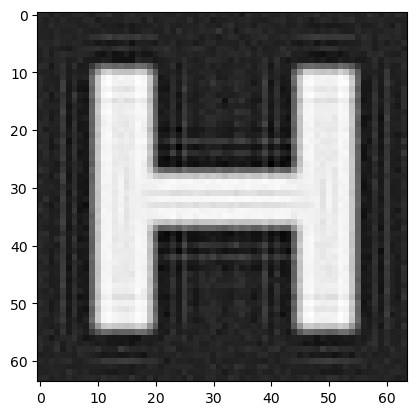

In [81]:
plt.imshow(solver.x.reshape(64,64), cmap='Greys_r')